# Gaussian Process Regression

By Christopher J. Moore & Zoheyr Doctor

Prepared for two 1.5 hour practical sessions held at the "Workshop on Reduced Order Gravitational-Wave Modeling" at the Max Planck Institute for Gravitational Physics, Potsdam from $18^{\textrm{th}}-22^{\textrm{nd}}$ of June, $2018$.


# Some Useful References

[RW] - The textbook "Gaussian Processes for Machine Learning", by Carl Edward Rasmussen and Christopher K. I. Williams, MIT Press (2006).

[ADLER] - The textbook "The Geometry of Random Fields", by R. J. Adler, Wiley Series in Probability and Mathematical Statistics (1981).

[MACKAY] - The textbook "Information Theory, Inference, and Learning Algorithms", by David J.C. MacKay, Cambridge University Press (2003).


# Table of Contents

1 Introduction

2 What is a Gaussian Processes?
 - 2.1 Gaussian, or "Normal", Random Variables
 - 2.2 Gaussian Processes
 - 2.3 Some Examples of Gaussian Processes
 - - 2.3.1 Straight Line
 - - 2.3.2 Brownian Motion
 - - 2.3.2 Squared Exponential

3 The Covariance Function
 - 3.1 Some General Terminology
 - 3.2 Bochner's Theorem
 - 3.3 Some Commonly Used Covariance Functions
 - - 3.3.1 SE
 - - 3.3.2 Matern
 - - 3.3.3 Wendland Polynomials
 - 3.4 Building New Covariance Functions From Old Ones
 - 3.5 Mean Square Continuity and Differentiability

4 Using Gaussian Processes for Regression
 - 4.1 Regression with Gaussian Processes
 
5 Gaussian Process Regression: A Gravitational Wave Example

6 Conclusions

# 1 Introduction

Regression is a general term for predicting the values of some continuous quantities.
A typically regression problem would involve predicting the value of some smooth function at a particular point given a set of (possibly noisy) observations at some other points. 

As we will see in this notebook, Gaussian processes can be used in a very elegant way to tackle regression problems. 
There are several reasons why one might want to use Gaussian process regression (GPR) instead of some other techniques.
GPR is very easy to implement and makes very few hidden assumptions about the nature of the underlying function. Furthermore, the method involves the specification of relatively few arbitrary parameters (or parameterisations), and for those that are required there is very natural Bayesian framework for selecting the best parameters. The technique can be easily applied to irregularly sampled data in any number of dimensions, and is flexible enough to allow for additional data to be added later, as it becomes avaiable.
The main disadvantage of GPR is the difficulty encoutered when trying to apply the methods to large data sets; it is typically difficult to apply the techniques that will be discussed in these notes to data sets containing more than around $10^{4}$ points. (Although generalisations of these techniques designed for large data sets do exist.)

In section 2 of these notes the concept of a Gaussian process is defined. The properties of a Gaussian process are governed principally by it's covariance function and the properties of the covariance function are the topic of section 3. The remainder of the notes are concerned with how to use Gaussian processes for regression.

This Jupyter notebook has been prepared to run with python 3, and we have attempted to ensure that it requires only standard libraries to run: numpy (tested with version 1.14.2), scipy (tested with version 0.19.1) and matplotlib (tested with version 2.1.0). In a small number of places the MCMC library $\textbf{emcee}$ (tested with version 2.2.1) and the plotting library $\textbf{corner}$ (tested with version 2.0.1) are also used. These can be installed from http://dfm.io/emcee/current/ and http://corner.readthedocs.io/en/latest/install.html respectively.
            

In [1]:
import numpy as np
print ( "numpy version" , np.__version__ )

import scipy
from scipy import linalg as LA
import scipy.optimize as spo
print ( "scipy version" , scipy.__version__ )

# uncomment to show matplotlib inline:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
print ( "matplotlib version" , matplotlib.__version__ )

# This is only used in a small number of places, don't worry if you don't have it.
import emcee as mc
print ( "emcee version" , mc.__version__ )

# This is only used in a small number of places, don't worry if you don't have it.
import corner
print ( "corner version" , corner.__version__ )


numpy version 1.14.2
scipy version 0.19.1
matplotlib version 2.1.0
emcee version 2.2.1
corner version 2.0.1


# 2 What is a Gaussian Process?

A Gaussian Process may be regarded as an infinite dimensional generalisation of the more familiar finite dimensional Gaussian random variable. Therefore we begin by recapping finite dimensional Gaussian (or "normal") random variables.

## 2.1 Gaussian, or "Normal", Random Variables

A continuous random variable $z\in\mathbb{R}$ is said to be Gaussian distributed if its probability density function (PDF) is given by

$$ P(z)\,\textrm{d}z = \frac{\exp\left(\frac{-1}{2}\left(\frac{z-\mu}{\sigma}\right)^{2}\right)}{\sqrt{2\pi\sigma^{2}}} \,\textrm{d}z \,, \hspace{1cm}\textrm{(2.1)} $$

where $\mu$ is the "mean" and $\sigma^{2}$ is the "variance";

$$\textrm{E}\left[ z \right] \equiv \int\textrm{d}z\,P(z)\,z = \mu \,, $$
$$\textrm{E}\left[ \left(z-\mu\right)^{2} \right] \equiv \int\textrm{d}z\,P(z)\left(z-\mu\right)^{2} = \sigma^{2} \,.$$

The variance must be non-negative; i.e. $\sigma^{2}\geq 0$.
Eq.(2.1) is clumbersome to write, so the following shorthand is usually adopted,

$$ z \sim \mathcal{N}(\mu,\sigma)\,. $$

$$\phantom{.}$$

A continuous random $N$-vector $\mathbf{z}^{\textrm{T}}=(z_{1},z_{2},\ldots,z_{N})\in\mathbb{R}^{N}$ is said to be distributed as a multivariate Gaussian if its probability density function (PDF) is given by

$$ P(\mathbf{z})\,\textrm{d}\mathbf{z} = \frac{\exp\left(\frac{-1}{2}(\mathbf{z}-\mathbf{\mu})^{\textrm{T}}\cdot\mathbf{K}^{-1}\cdot (\mathbf{z}-\mathbf{\mu})\right)}{\sqrt{(2\pi)^{N}\left|\mathbf{K}\right|}} \,\textrm{d}\mathbf{z} \,, \hspace{1cm}\textrm{(2.2)} $$

where $\mathbf{\mu}\in\mathbb{R}^{N}$ is the "mean" $N$-vector and $\mathbf{K}$ is the $N\times N$ "covariance" matrix;

$$\textrm{E}\left[ \mathbf{z} \right] \equiv \int\textrm{d}\mathbf{z}\,P(\mathbf{z})\mathbf{z} = \mathbf{\mu} \,, $$
$$\textrm{E}\left[ \left(\mathbf{z}-\mathbf{\mu}\right)\left(\mathbf{z}-\mathbf{\mu}\right)^{\textrm{T}} \right] \equiv \int\textrm{d}\mathbf{z}\,P(\mathbf{z})\left(\mathbf{z}-\mathbf{\mu}\right)\otimes\left(\mathbf{z}-\mathbf{\mu}\right)^{\textrm{T}} = \mathbf{K} \,. $$

Just as we had $\sigma^{2}\geq 0$ previously, here the covariance matrix must always be symmetric (i.e. $\mathbf{K}=\mathbf{K}^{\textrm{T}}$) and $\textbf{positive semi-definite}$. Eq.(2.2) is clumbersome to write, so the following shorthand is usually adopted,

$$ \mathbf{z} \sim \mathcal{N}(\mathbf{\mu},\mathbf{K})\,. $$

$\textbf{Definition: }$ A real $N\times N$ matrix $\mathbf{K}$ is $\textbf{positive semi-definite}$ if $\mathbf{u}^{\textrm{T}}\cdot\mathbf{K}\cdot\mathbf{u}\geq 0$ for any $N$-vector $\mathbf{u}\in\mathbb{R}^{N}$.

Furthermore, if $\mathbf{u}^{\textrm{T}}\cdot\mathbf{K}\cdot\mathbf{u} = 0 \Rightarrow \mathbf{u}=\mathbf{0}$ then $\mathbf{K}$ is said to be strictly positive definite.

$\textbf{Exercise: }$ Show that a symmetric matrix is positive semi-definite if and only if all of its eigenvalues are non-negative.


$$\phantom{.}$$

We will assume the reader is familiar with most of the properties of multivariate Gaussian distributions. However, we will point out that a Gaussian distribution is fully specified by just the mean $\mathbf{\mu}$ and the pairwise covariances $\mathbf{K}$ (all the higher order moments, e.g. $\textrm{E}\big[z_{1}\times z_{2} \times z_{3}\big]$, may be expressed in terms of just $\mathbf{\mu}$ and $\mathbf{K}$). We also poinrt our the "affine" property of Gaussian random variables which will be relevant in what follows; if $\mathbf{z} \sim \mathcal{N}(\mathbf{\mu},\mathbf{K})$ then for any $M$-vector $\mathbf{a}$ and $M\times N$ matrix $b$, the vector $\mathbf{y}=\mathbf{a}+\mathbf{b}\cdot\mathbf{z}$ is also a Gaussian random variable, $\mathbf{y}\sim\mathcal{N}(\mathbf{a}+\mathbf{b}\cdot\mathbf{\mu},\mathbf{b}\cdot\mathbf{K}\cdot\mathbf{b}^{\textrm{T}})$. In particular, this implies that any subset of the components of $\mathbf{z}$ is also a Gaussian random variable and the covariance matrix is given by the relevant subset of the components of $\mathbf{K}$.

$$\phantom{.}$$

It is easy to verify that the random $N$-vector $\mathbf{z}'=\mathbf{z}-\mathbf{\mu}$ is distributed as $\mathbf{z}' \sim \mathcal{N}(\mathbf{0},\mathbf{\Sigma})$. For this reason, it is usually possible to (without loss of generality) choose to work with zero-mean Gaussian random variables.

$$\phantom{.}$$

Gaussian random variables are well suppported in any sensible programming language; e.g. python$\ldots$



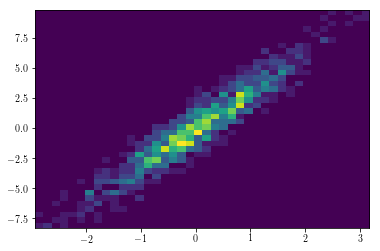

In [2]:
# Finite dimensional Gaussian random variables in python

# A mean 2-vector and a 2 by 2 covariance matrix
mu = np.array ( [ 0 , 0 ] )
K = np.array ( [ [ 1 , 3 ] , [ 3 , 10 ] ] )

# Draw 1000 realisations of the Gaussian random variable z~N(mu,K)
dist = np.array ( [ np.random.multivariate_normal ( mu , K ) for i in range ( 1000 ) ] )

# Plot the distribution of z
plt.hist2d ( dist[:,0] , dist[:,1] , bins=40 )
plt.show ( )


## 2.2 Gaussian Processes

Instead of distributions over a finite number of random variables (i.e. random vectors) we now wish to consider distributions over smooth random functions. For some set $\mathcal{S}$ we will consider real valued functions $\,f:\mathcal{S}\rightarrow\mathbb{R}$. The random variables will now be the values of the function evaluated at some particular input; i.e. $f(x)$ for $x\in\mathcal{S}$.

We will use the following definition of a Gaussian process (GP).

$\textbf{Definition }$ For any set $\mathcal{S}$, a $\textbf{Gaussian Process}$ on $\mathcal{S}$ is a collection of random variables $\{{f(x):x\in \mathcal{S}\}}$ such that for any finite ${n\in\mathbb{N}}$, and any ${x_{1},x_{2},\ldots,x_{n}\in\mathcal{S}}$, the vector ${\left(f(x_{1}),f(x_{2}),\ldots,f(x_{n})\right)^{\mathrm{T}}\in\mathbb{R}^{n}}$ is distributed as a multivariate Gaussian.

Notice that in this definition the set $\mathcal{S}$ can be either finite and infinite dimensional. However, the finite case is of little interest as this definition simply reduces to the familiar multivariate Gaussian discussed above.

$$\phantom{.}$$

$\textbf{An Example of a GP: }$ For this audience perhaps the most familiar example of a Gaussian process is the noise, $n(t)$, in a gravitational wave interferometer. 
The noise is a real valued function of time. 
The noise is usually assumed to be stationary and Gaussian, meaning that in the frequency domain $\textrm{E}\left[ {\widetilde{n}} (f) {\widetilde{n}} (f')^{*}\right]=\frac{1}{2}S_{n}(f)\delta(f-f')$. 
From the definition of the Fourier transform, it follows that in the time domain $\textrm{E}\left[n(t)n(t')\right]=\int_{0}^{\infty}S_{n}(f)\cos\left(2\pi f(t-t')\right) \equiv \kappa(t-t')$, using the Fourier transform conventions of [arXiv:1408.0740]. The function $S_{n}(f)$ is called the detector's one-sided noise power spectral density (usually given in units of $\textrm{Hz}^{-1}$).
Comparing with our above definition we see that the noise is a GP with $\mathcal{S}=\mathbb{R}$, $x=t$, and $z(x)=n(t)$. 
The vector of noise values observed at any finite collection of time values, $\mathbf{n}^{\mathrm{T}}\equiv\left(n(t_{1}),n(t_{2}),\ldots,n(t_{N})\right)$, is distributed as $\mathbf{n}\sim\mathcal{N}(\mathbf{0},\mathbf{K})$, where

$$\mathbf{K} = \begin{pmatrix} \kappa(t_{1}-t_{1}) & \kappa(t_{1}-t_{2}) & \ldots & \kappa(t_{1}-t_{N}) \\ \kappa(t_{2}-t_{1}) & \kappa(t_{2}-t_{2}) & \ldots & \kappa(t_{2}-t_{N}) \\ \vdots & \vdots & \ddots & \vdots \\ \kappa(t_{N}-t_{1}) & \kappa(t_{N}-t_{2}) & \ldots & \kappa(t_{N}-t_{N})  \end{pmatrix}\,.$$

$$\phantom{.}$$

Fortunately, it is very easy construct new GPs with any desired properties by simply specifying the desired mean ($\mu(x)=\textrm{E}\big[f(x)\big]$) and pairwise covariance ($k(x,x')=\textrm{E}\Big[\big(f(x)-\mu(x)\big)\big(f(x')-\mu(x')\big)\Big]$). We are free to choose any mean function, $\mu:\mathcal{S}\rightarrow\mathbb{R}$; just as with Gaussian distributions, we will usually work with zero-mean GPs, $\mu(x)=0$ for all $x\in\mathcal{S}$. We are also free to choose any "covariance function", $k:\mathcal{S}\times\mathcal{S}\rightarrow\mathbb{R}$, subject to some constraints to be discussed below. Extending the notation in equations (1.1) and (1.2), if a function $f(x)$ is drawn from a GP with mean function $\mu(x)$ and covariance function $k(x,x')$ then we write

$$f(x) \sim \mathcal{GP}( \, \mu(x) \, , \, k(x,x') \, ) \,. \hspace{3cm} \textrm{(2.3)}$$

From the definition of a GP, for any finite set of points $\mathbf{x}_{*}^{\textrm{T}} = (x_{1},x_{2},\ldots,x_{N})$ the $N$-vector $\mathbf{f}_{*}^{\textrm{T}}=\left(f(x_{1}),f(x_{2}),\ldots,f(x_{N})\right)$ must distributed as $\mathbf{f}_{*} \sim \mathcal{N}( \mathbf{M} , \mathbf{K} )$, where

$$ \begin{align} 
&\mathbf{M}^{\textrm{T}} = \big( \, \mu(x_{1}) \, , \, \mu(x_{2}) \, , \ldots , \, \mu(x_{N}) \, \big) \,, \hspace{2cm} &\textrm{(2.4)} \\
\textrm{and } \; &\mathbf{K} =  \begin{pmatrix} k(x_{1},x_{1}) & k(x_{1},x_{2}) & \ldots & k(x_{1},x_{N}) \\ k(x_{2},x_{1}) & k(x_{2},x_{2}) & \ldots & k(x_{2},x_{N}) \\ \vdots & \vdots & \ddots & \vdots \\ k(x_{N},x_{1}) & k(x_{N},x_{2}) & \ldots & k(x_{N},x_{N})  \end{pmatrix} \,. \hspace{2cm} &\textrm{(2.5)}
\end{align} $$

If this is to make any sense, then the matrix $\mathbf{K}$ formed in equation (2.5) had better be a valid be symmetric positive semi-definite covariance matrix. To ensure that this is always the case the covariance function $k(x,x')$ must be a $\textbf{symmetric}$ function (i.e. $k(x,x')=k(x',x)$) and a $\textrm{positive semi-definite}$ function.

$\textbf{Definition: }$ A covariance function $k:\mathcal{S}\times\mathcal{S}\rightarrow\mathbb{R}$ is $\textbf{positive semi-definite}$ if the $N\times N$ matrix $\mathbf{K}_{ij}=k(x_{i},x_{j})$ is positive semi-definite for all sets of points $x_{1},x_{2},\ldots,x_{n}\in\mathcal{S}$ and for all $N\in\mathbb{N}$.

In the context of Gaussian Process Regression (GPR), covariance functions are sometimes also known as "kernels".

$$\phantom{.}$$

Note that equation (2.3) defines a Gaussian process by specifying the mean and pairwise covariance between random variables. Defining the GP in this way ensures that internal inconsistancies can never arrise among any of the random variables in the GP. For example, if our GP specifies that for a pair of points $x_{1}$ and $x_{1}$ we have $(f(x_1),f(x_2))\sim\mathcal{N}\big(\left[0,0\right],\left[\left[k(x_1,x_1),k(x_1,x_2)\right],\left[k(x_2,x_1),k(x_2,x_2)\right]\right]\big)$, then the affine property of Gaussian distributions automatically ensures that $f(x_1)\sim\mathcal{N}\big(0,k(x_1,x_1)\big)$ and $f(x_2)\sim\mathcal{N}\big(0,k(x_2,x_2)\big)$, as required by the definition in equation (2.3). 


## 2.3 Some Examples of Gaussian Processes

### 2.3.1 Straight Line

Consider the Gaussian process on the real line ($\mathcal{S}=\mathbb{R}$) with $\mu(x) = 0$ and $k_{\textrm{line}}(x,x')=xx'$.

To show that this is indeed a valid GP we need to show that $k_{\textrm{line}}(x,x')$ is a symmetric positive semi-definite covariance function. It is obviously symmetric, but the positive definite property requires a proof. Consider the covariance matrix formed by acting $k_{\textrm{line}}$ pairwise on any finite set of points $\mathbf{x}=(x_{1},x_{2},\ldots,x_{n})$; the covariance matrix is $\mathbf{K}=\mathbf{x}\otimes\mathbf{x}^{\textrm{T}}$, or $\mathbf{K}_{ij}=\mathbf{x}_{i}\mathbf{x}_{j}$. To show that this matrix is positive semi-definite consider the sum $s=\mathbf{u}^{\textrm{T}}\cdot\mathbf{K}\cdot\mathbf{u}$, for some arbitrary $n$-vector $\mathbf{u}\in\mathbb{R}^{n}$. The sum may be rewritten as $s=\left(\mathbf{u}^{\textrm{T}}\cdot\mathbf{x}\right)^{2}$ which shows that $s\geq0$, and hence that $\mathbf{K}$ is a positive semi-definite matrix. Since this holds for any choice of the points $\mathbf{x}$ it follows that $k_{\textrm{line}}(x,x')$ is a positive semi-definite function.

Alternatively, we may show that $k_{\textrm{line}}(x,x')$ is positive semi-definite by considering the eigenvalues of the symmetric covariance matrix $\mathbf{K}=\mathbf{x}\otimes\mathbf{x}^{\textrm{T}}$. This matrix has one non-zero eigenvalue $\lambda=\left|\mathbf{x}\right|^{2} \geq 0$ corresponding to the eigenvector $\mathbf{x}$ (all the other eigenvectors vanish). Because all of the eigenvalues are non-negative for any choice of points $\mathbf{x}=(x_{1},x_{2},\ldots,x_{n})$, and for any $n\in\mathbb{N}$, the covariance function $k_{\textrm{line}}(x,x')$ is positive semi-definite.

We are now in a position to draw a random realisation from this GP. The code in the following cell defines the functions $\mu(x)$, $k_{\textrm{line}}(x,x')$, and the vector $\mathbf{x}_{*}$ which is chosen to be a densely sampled vector of points in the range $0\leq x < 10$. Try running the following cell several times to get a sense of the behaviour of this GP.


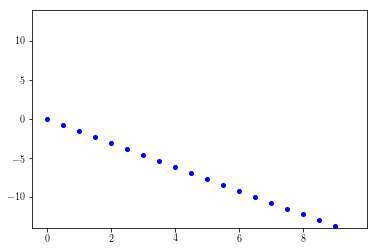

In [2]:
# Straight Line

# The mean function of the GP
def mu ( x ):
    return 0

# The covariance function of the GP
def k_line ( x , y ):
    return x * y

# The sampling points
x_star = np.arange ( 0 , 10 , 0.5 )

# The mean N-vector - formed from the mean function, mu
M = np.array ( [ mu(x) for x in x_star ] )

# The N by N covariance matrix - formed from the covariance function, k.
K = np.array( [ [ k_line(x,y) for x in x_star ] for y in x_star ] )

# A random realisation of the function values - drawn from the multivariate Gaussian distribution ~ N(M,K)
f_star = np.random.multivariate_normal ( M , K )

# Plot a realisation of the GP
plt.plot ( x_star , f_star , 'bo' , markersize=4 )
plt.ylim ( -14 , 14 )
plt.show ( )


$\textbf{Exercise:}$ If you were to run the above cell many times and record the gradients of lines obtained, what distribution would the gradients follow? 


### 2.3.2 Brownian Motion

Consider the Gaussian process on the positive real line ($\mathcal{S}=\mathbb{R}_{+}$) with $\mu(x) = 0$ and $k_{\textrm{Brownian}}(x,x')=\textrm{min}(x,x')$.

To show that this is a valid GP we need to show that $k_{\textrm{Brownian}}(x,x')$ is a symmetric positive semi-definite covariance function. As was the case in the previous example 2.3.1 the symmetry property is obvious, but the positive semi-definite property requires proof. 

$\textbf{Exercise:}$ Show that $k_{\textrm{Brownian}}(x,x')$ is a positive semi-definite function. 

$\textbf{Hint: }$ Let $H(t;x)=\begin{cases}1\quad\textrm{if }t\leq x\\0\quad\textrm{else}\end{cases}\,,$ and write the $\textrm{min}$ function as $\textrm{min}(x_{i},x_{j})=\int_{0}^{\infty}\textrm{d}t\;H(t;x_{i})H(t;x_{j})\,.$ 

We are now in a position to draw a random realisation from this GP. The code in the following cell defines the functions $\mu(x)$, $k_{\textrm{line}}(x,x')$, and the vector $\mathbf{x}_{*}$ which is chosen to be a densely sampled vector of points in the range $0\leq x < 10$. Try running the following cell several times to get a sense of the behaviour of this GP.

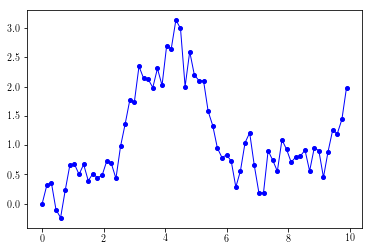

In [3]:
# Brownian Motion

# The mean function of the GP
def mu ( x ):
    return 0

# The covariance function of the GP
def k_Brownian ( x , y ):
    return min ( x , y )

# The sampling points
x_star = np.arange ( 0 , 10 , 0.15 )

# The mean N-vector - formed from the mean function, mu
M = np.array ( [ mu(x) for x in x_star ] )

# The N by N covariance matrix - formed from the covariance function, k.
K = np.array( [ [ k_Brownian(x,y) for x in x_star ] for y in x_star ] )

# A random realisation of the function values - drawn from the multivariate Gaussian distribution ~ N(M,K)
f_star = np.random.multivariate_normal ( M , K )

# Plot a realisation of the GP
plt.plot ( x_star , f_star , linewidth=1 , marker='o' , markersize=4 , color='b' )
plt.show ( )


### 2.3.3 Squared Exponential

Consider the Gaussian process on the real line ($\mathcal{S}=\mathbb{R}$) with $\mu(x) = 0$ and $k_{\textrm{SE}}(x,x')=\exp\left(-\frac{1}{2}(x-x')^{2}\right)$. This is a special case of the widely used "squared exponential" covariance function (see section 3.3.1).

The function $k_{\textrm{SE}}(x,x')$ is also symmetric positive semi-definite (see section 3.2).

We are now in a position to draw a random realisation from this GP. The code in the following cell defines the functions $\mu(x)$, $k_{\textrm{line}}(x,x')$, and the vector $\mathbf{x}_{*}$ which is chosen to be a densely sampled vector of points in the range $0\leq x < 10$. Try running the following cell several times to get a sense of the behaviour of this GP.

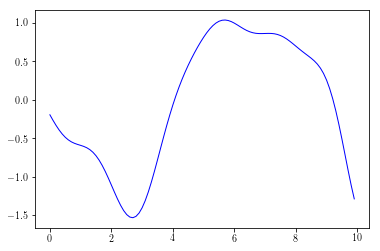

In [4]:
# Squared exponential

# The mean function of the GP
def mu ( x ):
    return 0

# The covariance function of the GP - this is an example of a "squared exponential" covariance function, see Sec.?
def k_SE ( x , y ):
    return np.exp ( -0.5 * (x-y) * (x-y) )

# The sampling points
x_star = np.arange ( 0 , 10 , 0.1 )

# The mean N-vector - formed from the mean function, mu
M = np.array ( [ mu(x) for x in x_star ] )

# The N by N covariance matrix - formed from the covariance function, k.
K = np.array( [ [ k_SE(x,y) for x in x_star ] for y in x_star ] )

# A random realisation of the function values - drawn from the multivariate Gaussian distribution ~ N(M,K)
f_star = np.random.multivariate_normal ( M , K )

# Plot a realisation of the GP
plt.plot ( x_star , f_star , linewidth=1 , color='b' )
plt.show ( )


$\textbf{Exercise:}$ The above cell generates random realisations of a squared exponential covariance function. Try modifying the covariance function to $k_{\textrm{SE}}(x,x')=\sigma_{f}^{2}\exp\left(\frac{-1}{2}\frac{(x-x')^{2}}{\ell^{2}}\right)$ and experiment with different choices of $\sigma_{f}$ and $\ell$. Explore how the these two "hyperparameters" (see Sec.3) control the properties of the GP. (You can also experiment with using a non-zero mean function, $\mu(x)$.) Also, try experimenting with using $k_{\textrm{?}}(x,x')=\exp\left(\frac{-1}{2}(x-x')^{3}\right)$; why doesn't this work?


Note that the examples in sections $2.3.1$ and $2.3.1$ had a special point at $x=0$. The squared-exponential does not have any such prefered point, it is in fact translation invariant; $k(x,x')=k(x+\Delta,x'+\Delta)$. A covariance function with this property is called "stationary" (see section 3.1).

Note also that in the example in section (2.3.3) we have choosen to stop drawing the curve with points and instead use a smooth curve. Of course, any practical computation involving GPs is performed on a finite number of points, so a list plot is more honest. However, the choice of the points $\mathbf{x}_{*}$ is arbitrary and is designed to show the smooth behaviour of the underlying GP, so perhaps the line plot is more appropriate.


# 3 The Covariance Function

In section 2 it was shown how a GP can be specified by a symmetric positive definite covariance function, $k(x,x')$. We also saw through several examples that this covariance function governs the properties of the GP. In this section several covariance functions which are commonly used for regression will be introduced in a more systematic way. In addition, a more formal discussion of how the covariance function governs the "smoothness" of the GP will also be presented in section 3.5.


## 3.1 Some General Terminology

The discussion in this section will be restricted to covariance functions of GPs on $\mathcal{S}=\mathbb{R}^{N}$. In what follows $x,x'\in\mathbb{R}^{N}$, angled brackets $\left<x|x'\right>$ denote the standard Euclidean inner product between the $N$-vectors $x$ and $x'$, and $|x|=\sqrt{\left<x|x\right>}$ denotes the standard Euclidean norm of $x$.

$\textbf{Definition: }$ A covariance function is said to be $\textbf{stationary}$ if it depends only on the difference of the inputs; i.e. $k(x,x')=k(\tau)$, where $\tau=x-x'$. A stationary covariance function is invariant under translations; i.e. $k(x,x')=k(x+\Delta,x'+\Delta)$.

$\textbf{Definition: }$ A stationary covariance function is said to be $\textbf{isotropic}$ if it is only a function of the Euclidean distance between the inputs; $k(x,x')=k(r)$, where $r=\left|x-x'\right|$. An isotropic covariance function is invariant under rotations as well as translations.


## 3.2 Bochner's Theorem

Section 2 introduced several examples of covariance functions and in each case it was necessary to prove that proposed covariance function was symmetric and positive semi-definite. The proof was different in each case, and in general there is no easy way to establish whether a particular function is positive semi-definite. (Although, it is usually easy to prove that a particular function is NOT positive semi-definite by simply evaluating the covariance matrix formed from a particular set of points and showing that this matrix has at least one negative eigenvalue.)

$\textbf{Exercise: }$ Show that the function $k(x,x')=\begin{cases} \exp(-(x-x')^{2}) &\;\textrm{if }|x-x'|<1 \\ 0 &\;\textrm{else} \end{cases}$ is NOT positive semi-definite.

$$\phantom{.}$$

Fortunately there is a theorem which allows us to easy establish whether any $\textbf{stationary}$ function, $k(\tau)$, is positive definite.

$\textbf{Bochner's Theorem: }$ A function $k:\mathcal{S}\rightarrow\mathbb{R}$ is the covariance function of a stationary mean square continuous GP on $\mathbb{R}^{N}$ if and only if it can be written as the following integral using a positive finite function $S(x)$ on $\mathbb{R}^{N}$;
$$k(\tau) = \int_{\mathbb{R}^{N}}\textrm{d}x \; S(x) \exp\big(2\pi i \left<x|\tau\right> \big) \,. $$

The function $S(x)$ is simply the Fourier transform of $k(\tau)$. 

In section 2 the squared exponential covariance function was introduced. Bochner's theorem may now be used to prove that this function is indeed positive definite. The Fourier transform of the squared exponential function is another squared exponential function, which is always positive. Therefore, by Bochner's theorem, the function $k_{SE}$ is positive definite. 

$\textbf{Exercise: }$ Show for a second time that the function $k(x,x')=\begin{cases} \exp(-(x-x')^{2}) &\;\textrm{if }|x-x'|<1 \\ 0 &\;\textrm{else} \end{cases}$ is NOT positive semi-definite, this time using Bochner's theorem.
         

## 3.3 Some Commonly Used Covariance Functions

In this section we will list some covariance functions for GPs on $\mathcal{S}=\mathbb{R}^{N}$ that have been widely used in the literature for regression.

In previous section, where several examples of covariance functions where introduced, the covariance functions were coded up in the simplest possible way. 
In this section the covariance functions will be coded up in a as python methods in a manner which is more suitable for implementation in a GPR algorithm.


### 3.3.1 Squared-Exponential Covariance

Let's start with probably the most widely used kernel, the squared exponential, which has the form:

$$k_{\textrm{SE}}(x,x') = \exp\left(-\frac{1}{2}\frac{||x-x'||^2}{l^2}\right)\,.$$

A slightly more general (and more flexible) version uses a non-trivial distance metric (Einstein summation convention is used here):

$$k_{\textrm{SE}}(x,x') = \exp\left(-\frac{1}{2}g_{ab}(x_a-x'_a)(x_b-x'_b)\right)\,.$$

The constants $l$ or the components of $g_{ab}$ are parameters to be chosen by the user. Alternatively, these parameters can be optimized for (see section X).

In the code cell below a squared exponential kernel method that will compute the $K$ matrix with $k({\bf x},{\bf x_*})$ between points $\texttt{X1}$ and $\texttt{X2}$ has been defined.


In [5]:
def squared_exponential_kernel ( X1 , X2 , scale=1.0 , metric=None ):
    """
    Computes the square exponential kernel.
    
    Parameters
    ----------
    X1: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X2
    X2: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X1
    scale: float or array with length ndim
        Squared exponential length scale 
    metric: callable
        A function that computes distances between
        two points.
        
    Returns
    -------
    K: matrix
        The covariance matrix for points in X
    """
    npoints1 = X1.shape[0]
    npoints2 = X2.shape[0]
    ndim = X1.shape[1]
    if isinstance(scale,(float,int)):
        inv_scale = (1./scale)*np.ones(ndim)
        inv_scale = np.diag(inv_scale)
    else:
        inv_scale = 1./scale
        inv_scale = np.diag(inv_scale)
    if metric == None:
        dist = lambda a,b: np.sqrt(np.dot(np.dot(a-b,inv_scale),a-b))
    else:
        dist = metric
    K = np.empty([npoints1,npoints2])
    for i in range(npoints1):
        for j in range(npoints2):
            try:
                K[i,j] = np.exp(-0.5*(dist(X1[i,:],X2[j,:])**2))
            except FloatingPointError:
                K[i,j]=0.
    return K


The squared exponential covariance function is stationary; i.e. $k(x,x')=k(\tau)$, where $\tau=|x-x'|$. In the cell below the function $k(\tau)$ is plotted for the parameter values $l=1$.

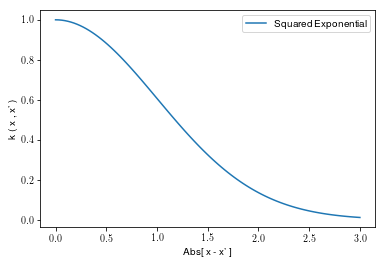

In [21]:
x_values = np.linspace(0,3,100)

X1 = np.array ( [ [x] for x in x_values ] )
X2 = np.array ( [ [0] for i in range(len(X1)) ])

y_values = squared_exponential_kernel ( X1 , X2 , scale=1.0 , metric=None )[:,0]

plt.plot ( x_values , y_values , label='Squared Exponential' )
plt.xlabel ( "t" )
plt.ylabel ( "k ( t )" )
plt.legend()
plt.show()


Just as was done in section 2, it is possible to generate random realisations from this GP to get a sense of the behaviour of the functions. The code cell below generates 5 such random realisations and plots them on top of each other.

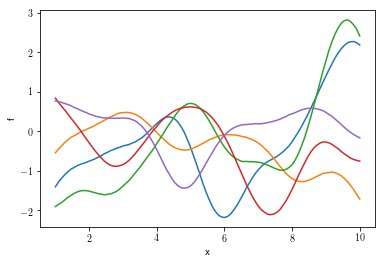

In [30]:
X = np.linspace(1,10,100).reshape(-1,1)

K = squared_exponential_kernel ( X , X , scale=1 , metric=None )

nugget_val = 1e-5
nugget = np.diag ( nugget_val * np.ones(X.shape[0]) )

for i in range(5):
    f = np.random.multivariate_normal ( np.zeros(K.shape[0]) , K+nugget )
    plt.plot(X,f)
    
plt.xlabel('x')
plt.ylabel('f')

plt.show()


$\textbf{Exercise: }$ Rerun the above cell with a different value for the length scale, $l$, and observe how the functions change.

$\textbf{Exercise: }$ Modify the above cell such that it can uses a square exponential covariance function with a different overall scale, $\sigma_{f}$; 

$$k_{\textrm{SE}}(x,x') = \sigma_{f}^{2}\exp\left(-\frac{1}{2}\frac{||x-x'||^2}{l^2}\right)\,.$$

### 3.3.2 Matern Covariance

When working with an isotropic covariance function (including the squared exponential described above in section 3.3.1) it is often convenient to define the scaled distance between two points $x,x'\in\mathcal{S}$;

$$ r(x,x') = \frac{|x-x'|}{l} \,. $$

Or a slightly more general version using a non-trivial distance metric;

$$ r(x,x') = \sqrt{g_{ab}(x_a-x'_a)(x_b-x'_b)} \,. $$

Following the conventions in [RW] the Matern class of kernels are defined as:

$$ k_{\textrm{Matern}}(r) = \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\sqrt{2\nu}r\right)^{\nu} K_\nu\left(\sqrt{2\nu}r\right)\,. $$

The parameters $\nu$ and $l$ are positive numbers and $K_\nu(x)$ denotes the modified Bessel functions of the first kind.  While any value of $\nu$ can be chosen in principle, one often chooses $\nu$ to be a half integer value, because the covariance can then be written in the somewhat simpler form,

$$ k_{\nu=p+1/2}(r) = \exp\left(\sqrt{2\nu}r\right) \frac{\Gamma(p+1)}{\Gamma(2p+1)} \sum_{i=0}^{p} \frac{(p+i)!}{i!(p-i)!}  \left(\sqrt{8\nu}r\right)^{p-i}\,. $$

[RW] claim that the $\nu=3/2$ and $\nu=5/2$ kernels are the most important for machine learning, and they also have the added benefit of having even simpler forms:

$$ k_{\nu = 3/2}(r) = \left(1+\sqrt{3}r\right) \exp\left(-\sqrt{3}r\right) \,, $$

$$ k_{\nu = 5/2}(r) = \left(1+\sqrt{5}r + \frac{5r^2}{3} \right) \exp\left(-\sqrt{5}r\right) \,. $$

Perhaps the most interesting aspect of the Matern kernels is that the level of smoothness of the underlying GP can be controlled via the parameter $\nu$. In fact, the GP is $n$-times mean-square differentiable where $n<\nu$ (see section 3.5 on mean square differentiability). As $\nu\rightarrow\infty$, a GP described by the Matern kernels become infinitely mean square differentiable. In fact, as $\nu\rightarrow\infty$ the Matern kernel actually recovers the squared-exponential kernel! 

In the code cell below the Matern 3/2 and Matern 5/2 kernels have been defined as Python methods that will compute the $K$ matrix with $k({\bf x},{\bf x_*})$ between points $\texttt{X1}$ and $\texttt{X2}$ has been defined. 


In [23]:
def Matern32 ( X1 , X2 , scale=1.0 , metric=None ):
    """
    Computes Matern 3/2 kernel
    
    Parameters
    ----------
    X1: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X2
    X2: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X1
    scale: float or array with length ndim
        Squared exponential length scale 
    metric: callable
        A function that computes distances between
        two points.
        
    Returns
    -------
    K: matrix
        The covariance matrix for points in X
    """
    npoints1 = X1.shape[0]
    npoints2 = X2.shape[0]
    ndim = X1.shape[1]
    if isinstance(scale,(float,int)):
        inv_scale = (1./scale)*np.ones(ndim)
        inv_scale = np.diag(inv_scale)
    else:
        inv_scale = 1./scale
        inv_scale = np.diag(inv_scale)
    if metric == None:
        dist = lambda a,b: np.sqrt(np.dot(np.dot(a-b,inv_scale),a-b))
    else:
        dist = metric
    K = np.empty([npoints1,npoints2])
    for i in range(npoints1):
        for j in range(npoints2):
            try:
                K[i,j] = (1.+np.sqrt(3)*dist(X1[i,:],X2[j,:]))*np.exp(-np.sqrt(3)*dist(X1[i,:],X2[j,:]))
            except FloatingPointError:
                K[i,j]=0.
    return K



def Matern52 ( X1 , X2 , scale=1.0 , metric=None ):
    """
    Computes Matern 5/2 kernel
    
    Parameters
    ----------
    X1: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X2
    X2: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X1
    scale: float or array with length ndim
        Squared exponential length scale 
    metric: callable
        A function that computes distances between
        two points.
        
    Returns
    -------
    K: matrix
        The covariance matrix for points in X
    """
    npoints1 = X1.shape[0]
    npoints2 = X2.shape[0]
    ndim = X1.shape[1]
    if isinstance(scale,(float,int)):
        inv_scale = (1./scale)*np.ones(ndim)
        inv_scale = np.diag(inv_scale)
    else:
        inv_scale = 1./scale
        inv_scale = np.diag(inv_scale)
    if metric == None:
        dist = lambda a,b: np.sqrt(np.dot(np.dot(a-b,inv_scale),a-b))
    else:
        dist = metric
    K = np.empty([npoints1,npoints2])
    for i in range(npoints1):
        for j in range(npoints2):
            try:
                K[i,j] = (1.+np.sqrt(5)*dist(X1[i,:],X2[j,:])+
                          (5./3)*(dist(X1[i,:],X2[j,:]))**2.)*np.exp(-np.sqrt(5)*dist(X1[i,:],X2[j,:]))
            except FloatingPointError:
                K[i,j]=0.
    return K


The Matern covariance function is stationary; i.e. $k(x,x')=k(\tau)$, where $\tau=|x-x'|$. In the cell below the function $k(\tau)$ is plotted for the parameter values $\nu=3/2$ and $\nu=5/2$ (in both cases $l=1$).

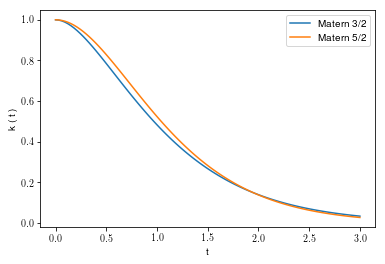

In [24]:
x_values = np.linspace(0,3,100)

X1 = np.array ( [ [x] for x in x_values ] )
X2 = np.array ( [ [0] for i in range(len(X1)) ])

y1_values = Matern32 ( X1 , X2 , scale=1.0 , metric=None )[:,0]
y2_values = Matern52 ( X1 , X2 , scale=1.0 , metric=None )[:,0]

plt.plot ( x_values , y1_values , label='Matern 3/2' )
plt.plot ( x_values , y2_values , label='Matern 5/2' )
plt.xlabel ( "t" )
plt.ylabel ( "k ( t )" )
plt.legend()
plt.show()


The code cell below generates 5 random realisations from Matern covariance function (with $\nu=3/2$ and $\nu=5/2$) and plots them on top of each other.

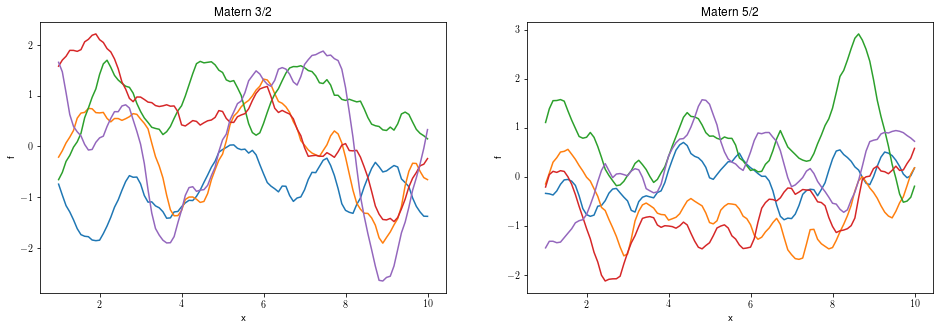

In [43]:
X = np.linspace(1,10,100).reshape(-1,1)

K1 = Matern32 ( X , X , scale=1 , metric=None )

nugget_val = 1e-5
nugget = np.diag ( nugget_val * np.ones(X.shape[0]) )

fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
for i in range(5):
    f = np.random.multivariate_normal ( np.zeros(K1.shape[0]) , K1+nugget )
    ax1.plot(X,f)

ax1.set_title('Matern 3/2')
ax1.set_xlabel('x')
ax1.set_ylabel('f')
    
K2 = Matern32 ( X , X , scale=1 , metric=None )

ax2 = fig.add_subplot(122)
for i in range(5):
    f = np.random.multivariate_normal ( np.zeros(K2.shape[0]) , K2+nugget )
    ax2.plot(X,f)

ax2.set_title('Matern 5/2')
ax2.set_xlabel('x')
ax2.set_ylabel('f')

plt.show()


$\textbf{Exercise: }$ Using the above Matern 5/2 and 3/2 examples as a template write a python method for the general Matern kernel. Can you think of some real world examples where you might a priori know to use each of these kernels?

$\textbf{Exercise: }$ Use the new kernel that you have just created to generate random realisations from the GP. Observe what happens to the behaviour of the functions in the limit that $\nu$ becomes large.

### 3.3.3 Wendland Polynomial Covariance

It is possible to write kernels that are positive semi-definite and that have *compact support*.  Compact support just means that the kernel falls to exactly zero outside some radius.  The advantage of using compact support kernels is that some (hopefully many!) elements of the covariance matrix go to zero, allowing faster matrix inversion.  Writing such kernels is not trivial, but one class of examples was put forward by [Wendland (1995)](https://link.springer.com/article/10.1007/BF02123482).  Rasmussen and Williams offer the following examples of some of these polynomials $k_{D,q}$, which work up to dimension D and are q-times mean-square differentiable:

$$
\begin{align}
k_{D,0}(r) =& (1-r)_+^j \\
k_{D,1}(r) =& (1-r)_+^{j+1} \left((j+1)r + 1\right) \\
k_{D,2}(r) =& (1-r)_+^{j+2}\left((j^2+4j+3)r^2 + (3j+6)r + 3\right)/3 \\
k_{D,3}(r) =& (1-r)_+^{j+3} \\
& \times \left((j^3 + 9j^2 + 23j + 15)r^3 + (6j^2 + 36j + 45)r^2 + (15j + 45)r + 15\right)/15
\end{align}
$$

In these expressions, $j=\left \lfloor{\frac{D}{2}}\right \rfloor + q + 1$ and the notation $\left[x\right]_{+}=\mathrm{max}(0,x)$ has been used.
Below is a Python method to construct covariance matrices from these polynomials

In [25]:
def WPolyq(r,j,q):
    """
    Wendland polynomial calculator
    
    Parameters
    ----------
    r: float
        distance
    j: int
        j = floor(D/2) + q + 1
    q: int
        number of times resulting
        distributions are 
        mean-square differentiable
        
    Returns
    -------
    res: float
        value of Wendland polynomial
    """
    
    if r > 1:
        res = 0
    elif q==0:
        res = (1.-r)**j
    elif q==1:
        res = ((1.-r)**(j+1)) * ((j+1)*r + 1)
    elif q==2:
        res = ((1.-r)**(j+2)) * ((j**2 + 4*j + 3) * (r**2)
                                + (3*j+6) * r
                                + 3
                                )/3
    elif q==3:
        res = (((1.-r)**(j+3)) 
           * ((j**3 + 9*(j**2) + 23*j + 15) * (r**3)
             + (6*(j**2) + 36*j + 45) * (r**2)
             + (15*j + 45) * r
             + 15
             )/15
          ) 
    return res


def WendlandPolynomialKernel( X1 , X2 , scale=1.0 , metric=None , D=None, q=0):
    """
    Computes Wendland Polynomial
    covariance matrices
    
    Parameters
    ----------
    X1: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X2
    X2: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X1
    scale: float or array with length ndim
        Squared exponential length scale 
    metric: callable
        A function that computes distances between
        two points.
    D: integers 0 to 3
        Max number of dimensions for which the 
        covariance is positive-semi-definite.
        Defaults number of input dimensions in X1
    q: integer
        Resulting distributions are q-times 
        mean-square differentiable
        
    Returns
    -------
    K: matrix
        The covariance matrix for points in X1 and X2
    """
    npoints1 = X1.shape[0]
    npoints2 = X2.shape[0]
    ndim = X1.shape[1]
    
    if D==None:
        D = ndim
    
    # define j as in R&W
    j = np.floor(D/2.)+q+1
    
    if isinstance(scale,(float,int)):
        inv_scale = (1./scale)*np.ones(ndim)
        inv_scale = np.diag(inv_scale)
    else:
        inv_scale = 1./scale
        inv_scale = np.diag(inv_scale)
    if metric == None:
        dist = lambda a,b: np.sqrt(np.dot(np.dot(a-b,inv_scale),a-b))
    else:
        dist = metric
    K = np.empty([npoints1,npoints2])

    for i in range(npoints1):
        for p in range(npoints2):
            K[i,p] = WPolyq(dist(X1[i,:],X2[p,:]),j,q)
    return K


The Wendland polynomial covariance functions are stationary; i.e. $k(x,x')=k(\tau)$, where $\tau=|x-x'|$. In the cell below the function $k(\tau)$ is plotted for the parameter values $q=0$, $q=1$, $q=2$, and $q=3$ (in all cases $l=1$ and $D=1$).

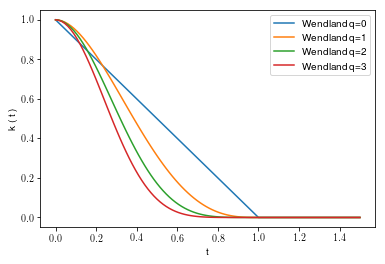

In [50]:
x_values = np.linspace(0,1.5,100)

X1 = np.array ( [ [x] for x in x_values ] )
X2 = np.array ( [ [0] for i in range(len(X1)) ])

y1_values = WendlandPolynomialKernel ( X1 , X2 , scale=1.0 , metric=None, D=1, q=0 )[:,0]
y2_values = WendlandPolynomialKernel ( X1 , X2 , scale=1.0 , metric=None, D=1, q=1 )[:,0]
y3_values = WendlandPolynomialKernel ( X1 , X2 , scale=1.0 , metric=None, D=1, q=2 )[:,0]
y4_values = WendlandPolynomialKernel ( X1 , X2 , scale=1.0 , metric=None, D=1, q=3 )[:,0]

plt.plot ( x_values , y1_values , label='Wendland q=0' )
plt.plot ( x_values , y2_values , label='Wendland q=1' )
plt.plot ( x_values , y3_values , label='Wendland q=2' )
plt.plot ( x_values , y4_values , label='Wendland q=3' )
plt.xlabel ( "t" )
plt.ylabel ( "k ( t )" )
plt.legend()
plt.show()


The code cell below generates 5 random realisations from Matern covariance function (with $\nu=3/2$ and $\nu=5/2$) and plots them on top of each other.

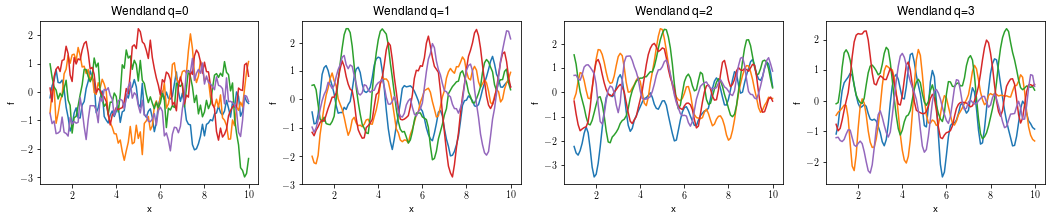

In [48]:
X = np.linspace(1,10,100).reshape(-1,1)

K1 = WendlandPolynomialKernel ( X , X , scale=1 , metric=None, D=1, q=0 )

nugget_val = 1e-5
nugget = np.diag ( nugget_val * np.ones(X.shape[0]) )

fig = plt.figure(figsize=(18,3))

ax1 = fig.add_subplot(141)
for i in range(5):
    f = np.random.multivariate_normal ( np.zeros(K1.shape[0]) , K1+nugget )
    ax1.plot(X,f)

ax1.set_title('Wendland q=0')
ax1.set_xlabel('x')
ax1.set_ylabel('f')
    
K2 = WendlandPolynomialKernel ( X , X , scale=1 , metric=None, D=1, q=1 )

ax2 = fig.add_subplot(142)
for i in range(5):
    f = np.random.multivariate_normal ( np.zeros(K2.shape[0]) , K2+nugget )
    ax2.plot(X,f)

ax2.set_title('Wendland q=1')
ax2.set_xlabel('x')
ax2.set_ylabel('f')

K3 = WendlandPolynomialKernel ( X , X , scale=1 , metric=None, D=1, q=2 )

ax3 = fig.add_subplot(143)
for i in range(5):
    f = np.random.multivariate_normal ( np.zeros(K3.shape[0]) , K3+nugget )
    ax3.plot(X,f)

ax3.set_title('Wendland q=2')
ax3.set_xlabel('x')
ax3.set_ylabel('f')

K4 = WendlandPolynomialKernel ( X , X , scale=1 , metric=None, D=1, q=3 )

ax4 = fig.add_subplot(144)
for i in range(5):
    f = np.random.multivariate_normal ( np.zeros(K4.shape[0]) , K4+nugget )
    ax4.plot(X,f)

ax4.set_title('Wendland q=3')
ax4.set_xlabel('x')
ax4.set_ylabel('f')

plt.show()


## 3.4 Building New Covariance Functions From Old Ones

Given one or more "seed" covariance functions there are several useful ways to construct new covariance functions. 

$\textbf{Summation: }$ For any two covariance functions, $k_{1}(x,x')$ and $k_{2}(x,x')$, the sum $k(x,x')=k_{1}(x,x')+k_{2}(x,x')$ is a new covariance function.

$\textbf{Product: }$ For any two covariance functions, $k_{1}(x,x')$ and $k_{2}(x,x')$, the product $k(x,x')=k_{1}(x,x')\times k_{2}(x,x')$ is a new covariance function.

$\textbf{Warping: }$ For any covariance function $k(x,x')$, and any "warping" function $u:\mathcal{S}\rightarrow\mathcal{S}$, the function $k(\,u(x)\,,\,u(x')\,)$ is a new covariance function.

$\textbf{Renormalisation: }$ For any covariance function $k(x,x')$, and any function $\alpha:\mathcal{S}\rightarrow\mathbb{R}$, the combination $\alpha(x)k(x,x')\alpha(x')$ is a new covariance function.

$$\phantom{.}$$

$\textbf{Exercise: }$ Prove that all of the above procedures do indeed generate new symmetric positive semi-definite covariance functions.


## 3.5 Mean Square Continuity and Differentiability

This section can be skipped. The material in this section is not needed to understand the implementation of the Gaussian process regression algorithm in section 4.

In this section it will be shown how certain properties of the covariance function are responsible for governing the continuity and differentiability of the Gaussian process (GP). 

Here, the notion $\textbf{mean square continuity}$ is used (defined below in equation (3.1)); other defintions of GP continuity exists, but the notion used here relates can be most easily related to the covariance function. For more mathematical details on the topics discussed in this section see [ADLER].

$$\phantom{.}$$

Consider a Gaussian process, $f$, on the set $\mathcal{S}=\mathbb{R}^{n}$;

$$f(x) \sim \mathcal{GP}( \, \mu(x) \, , \, k(x,x') \, ) \,. $$

The smoothness and differentiability properties of $f$ at some particular point $x_{*}\in\mathbb{R}^{n}$ will be considered.
Let $x_{1},x_{2},x_{3}\ldots\in\mathbb{R}^{n}$ be a sequence of points which converge to $x_{*}$ in the sense that $\lim_{\ell\rightarrow\infty}\left|x_{\ell}-x_{*}\right|=0$, where $|\cdot|$ denotes the usual Euclidean norm.

The process $f(x)$ is said to be mean square continuous at $x_{*}$ if

$$\lim_{\ell\rightarrow\infty}\,\mathrm{E}\Big[\big(f(x_{*})-f(x_{\ell})\big)^{2}\Big]=0 \, , \hspace{2cm} \textrm{(3.1)}$$ 

The quantity $f(x_{*})$ is called the mean square limit of the the process $f(x)$ and this is denoted as

$$ f(x_{*}) = \mathrm{l.i.m.}_{\ell\rightarrow\infty}\,f(x_{\ell}) \,, $$

where $\mathrm{l.i.m.}$ stands for limit in mean square.

$$\phantom{.}$$

It should be noted that mean square continuity automatically implies continuity of the mean,

$$ \lim_{\ell\rightarrow\infty}\,\mathrm{E}\big[f(x_{\ell})-f(x_{*})\big] = 0 \,.  \hspace{2cm} \textrm{(3.2)}$$

$\textbf{Exercise: }$ Prove the result for the continuity of the mean stated in equation (3.2).

$\textbf{Hint: }$ Consider the variance of the quantity $\big(f(x_{\ell})-f(x_{*})\big)$.


$$\phantom{.}$$

It will now be shown how the mean square continuity of the GP can be related to properties of the covariance function.

$\textbf{Lemma: }$ If the random process $f$ is continuous in mean square at $x_{∗}$ then covariance function $k(x,x′)$ is continuous in the usual sense at the point $x=x′=x_{∗}$. 

$\textbf{Proof: }$ The mean and covariance of the process $f$ are, by definition, given by

$$ \mu(x) = \mathrm{E}\big[f(x)\big] \,, $$
$$ k(x,x') = \mathrm{E}\Big[\big(f(x)-\mu(x)\big)\big(f(x')-\mu(x')\big)\Big] \,. $$

The condition for mean square continuity is given in equation (3.1), this may be rewritten as

$$ \lim_{\ell\rightarrow\infty}\,\Big( k(x_{*},x_{*})-2k(x_{\ell},x_{*})+k(x_{\ell},x_{\ell}) + \big(\mu(x_{*})-\mu(x_{\ell})\big)^{2} \Big) = 0 \,. $$

(It is relativiely easy to check this by using the defitions for $\mu(x)$ and $k(x,x')$ and expanding everything out.)

If the process $f$ is mean square continous then it is also continuous in the mean; using the continuity of the mean gives

$$ \lim_{\ell\rightarrow\infty}\, \big( k(x_{*},x_{*}) -2k(x_{*},x_{\ell}) + k(x_{\ell},x_{\ell})\big) = 0 \,. $$

This is satisfied if the covariance function is continuous in the usual sense at the point $x=x'=x_{*}$.

$\textbf{Comments: }$ In fact, a GP is continuous in mean square if $\textbf{and only if}$ the covariance function is continuous at $x=x′=x_{∗}$, although this is not proved here.
For a stationary covariance function (i.e. $k(x,x')=k(\tau)$, where $\tau=x-x'$) checking if this condition holds reduces to simply checking the continuity of $k(\tau)$ at the point $\tau=0$.

$$\phantom{.}$$

We now move on from considering continuity to consider differentiability. 
In the spirit of the above the notion of taking the mean square derivative of a GP is defined as

$$ \frac{\partial f(x)}{\partial x^{i}} = \mathrm{l.i.m.}_{\epsilon\rightarrow 0} \mathcal{X}_{i}(x) $$

where

$$ \mathcal{X}_{i}(x) = \frac{f(x+\epsilon \mathbf{e}_{i})-f(x)}{\epsilon} $$

where $\mathbf{e}_{i}$ is the unit vector in the $i$-direction, and the $\textrm{l.i.m.}$ is the limit in mean square. 
This definition can be easily extended to higher-order derivatives. 
The mean square derivative of a GP is also a GP; this is a consequence of the fact that the sum of two Gaussian random variables is also distributed as a Gaussian random variable.

$\textbf{Lemma: }$ The covariance function of the GP $\frac{\partial^{2}k(x,x′)}{\partial x_{i}\partial x′_{i}}$. 

$\textbf{Proof: }$ 
Let $X_{i}(x)=\mathrm{E}\left[\mathcal{X}_{i}(x)\right]$.
By definition, the covariance of the quantity $\mathcal{X}_{i}(x)$ is given by

$$ K_{\epsilon}(x,x') = \mathrm{E}\left[ \left(\mathcal{X}_{i}(x)-X_{i}(x)\right)\left(\mathcal{X}_{i}(x')-X_{i}(x')\right)  \right] \,. $$

It follows that

$$ K_{\epsilon}(x,x') = \frac{k(x+\epsilon,x'+\epsilon)-k(x,x'+\epsilon)}{\epsilon^{2}} - \frac{k(x+\epsilon,x')-k(x,x')}{\epsilon^{2}} \,. $$

Taking the limit gives the result $\Box$

$\textbf{Comments: }$ By extension, the covariance function of the GP $\frac{\partial^{n} f(x)}{\partial x_{i1} \partial x_{i1} \ldots \partial x_{in}}$ is given by $\frac{\partial^{2n}k(x,x′)}{\partial x_{i1}\partial x′_{i1}\partial x_{i2}\partial x′_{i2}\ldots \partial x_{in}\partial x′_{in}}$. 
From the above results relating the mean square continuity of GPs to the continuity of the covariance function at $x=x'=x_{*}$, it follows that the $n^{\mathrm{th}}$ mean square derivative of the GP is mean square continuous (i.e. the GP is $n$-times mean square differentiable) if the $2n^{\mathrm{th}}$ regular derivative of the covariance function is continuous at $x=x'=x_{*}$. Notice that it is again the smoothness properties of the covariance function along the diagonal points that determines the differentiability of the GP. It can also be shown that if a covariance function is continuous at all diagonal points $x=x'$ then it’s everywhere continuous. (For a stationary GP it is sufficient to check the continuity of $k(\tau)$ at $\tau=0$.)

$$\phantom{.}$$

$\textbf{Exercise: }$ Use these results to establish the level of mean square differentiability of GPs with the squared exponential Matern kernels. Go back to section (3.3.2) and rerun the code cells to generate more realisations of the Matern GP with different values of $\nu$ and observe the smoothness properties. 

# 4 Gaussian Processes Regression



## 4.1 Regression with Gaussian Processes

In the examples presented thus far, random samples have been generated from some covariance matrices that describes the full joint distribution on function values.  In Gaussian process regression, one is interested in the _conditional_ distributions of function values.  We seek to infer possible (unknown) function values conditioned on some known values of the function. We can write the joint probability distribution of unknown function values ${\bf f}_*$ at some target points $X_*$ and the known values ${\bf f}$ at some sample points $X$ as:

$$p([{\bf f}, {\bf f}_*]) = \frac{1}{(2\pi)^{n/2}|K|^{1/2}}\exp\left(-\frac{1}{2}[{\bf f}, {\bf f}_*]^\top K^{-1}[{\bf f}, {\bf f}_*]\right) \hspace{2cm} \textrm{(4.1)}$$

Let's define:
$$\Gamma = K^{-1} = 
\begin{pmatrix} 
\Gamma_{XX} & \Gamma_{XX_*}  \\ 
\Gamma_{XX_*} & \Gamma_{X_*X_*}  \\
\end{pmatrix}, 
K=
\begin{pmatrix} 
K_{XX} & K_{XX_*}  \\ 
K_{X_*X} & K_{X_*X_*}  \\
\end{pmatrix}$$

If we condition on known ${\bf f}$, then all terms with only ${\bf f}$'s become constants and can be ignored:

$$
\begin{align}
p({\bf f}_*|{\bf f}) & \propto \exp\left(-\frac{1}{2} {\bf f_*}^\top\Gamma_{X_*X_*}{\bf f_*} - {\bf f}^\top\Gamma_{XX_*}{\bf f_*}\right) \hspace{2cm} \textrm{(4.2)}\\
& 
\end{align}
$$ 

The relations between the submatrices of $\Gamma$ and $K$ are:

$$\Gamma_{XX_*} = -K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}$$
$$\Gamma_{X_*X_*} = \left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}$$

The $K$ matrices are the covariances between test and/or input values of $f(x)$.  Substituting those into Equation (4.2) yields:

$$p({\bf f}_*|{\bf f})  \propto \exp\left(-\frac{1}{2} {\bf f_*}^\top\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}{\bf f_*} - {\bf f}^\top\left(-K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}\right){\bf f_*}\right)$$

We can complete the square by adding this term in the exponential:

$$-\frac{1}{2}{\bf f}^\top\left(K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}K_{X_*X}K_{XX}^{-1}\right){\bf f}$$

Notice that this term is independent of ${\bf f}_*$, so adding it in the exponential only affects the normalization.  After completing the square, we get 

$$p({\bf f}_*|{\bf f})  \propto \exp\left(-\frac{1}{2}({\bf f}_* - K_{X_*X}K_{XX}^{-1}{\bf f})^\top\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}({\bf f}_* - K_{X_*X}K_{XX}^{-1}{\bf f})\right)$$

We see that this is now a multivariate Gaussian with mean $K_{X_*X}K_{XX}^{-1}{\bf f}$ and covariance $K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}$.  This result is the workhorse of Gaussian process regression, and we summarize it here:

$$ p({\bf f}_*|{\bf f}) \sim \mathcal{N}\left(K_{X_*X}K_{XX}^{-1}{\bf f}, \hspace{0.2cm} K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right) \hspace{2cm} \textrm{(4.3)}$$

Let's take a second to digest this equation.  First, we can see that the mean values of ${\bf f}_*$ are generated by a linear transformation of the input values ${\bf f}$. Second, the variance of the conditional distribution is independent of ${\bf f}$ -- it only depends on the $K$ matrices, which are constructed only from $X$, $X_*$ and the kernel.  Therefore, local behavior of the values of ${\bf f}$ does not affect the predicted conditional variances. Also note that the first term of the conditional covariance is simply the prior covariance $K_{X_*X_*}$ and from it is subtracted $K_{X_*X}K_{XX}^{-1}K_{XX_*}$.  This second term is large when values of $K_{X_*X}$ and $K_{XX_*}$ are large and/or $K_{XX}$ values are small. Thus if a kernel such as the squared-exponential is used, where the covariance falls off with the distance between parameter values, ${\bf f}_*$ will be distributed like the prior if $X_*$ are "far away" from $X$ since the second term will go to zero.   

## 4.2 Computing a GPR

Now that we have Equation 4.3, let's perform some regression!  To do this, we'll need to choose on of the covariance functions described in section 3.3 and we'll require a bit more machinery in terms of practically performing the matrix operations required on a computer. 


Now let's condition the GP we created with our squared-exponential kernel.  To do this, we need to take the inverse of $K_{XX}$.  We will effectively do this via the Cholesky decomposition, which decomposes a matrix $K$ as $K=LL^\top$, where $L$ and $L^\top$ are lower and upper triangular matrices, respectively. Rather than directly find the inverse of $K$, we can solve for the vector ${\bf x}$ which fulfills the equation:
$$ {\bf y} = K{\bf x} = LL^\top{\bf x}$$
We write the solution as ${\bf x} = K\setminus {\bf y}$.  Substituting in the triangular matrices, we have ${\bf x} = L^\top\setminus (L \setminus {\bf y})$.  To solve for ${\bf b} = L \setminus {\bf y}$, use forward substitution and for $x = L^\top\setminus {\bf b}$ use backward substitution. With this inversion scheme in hand, we can write the numerical procedure algorithmically as (following Rasmussen and Williams Algorithm 2.1):

1. $L := {\rm Cholesky}(K)$
2. ${\bf \alpha} := L^\top \setminus (L \setminus {\bf f})$
3. ${\bf \bar{f}_*} := {\bf k}_*^\top {\bf \alpha}$
4. ${\bf v} := L \setminus {\bf k}_*$
5. $\mathbb{V} := {\bf k}_* - {\bf v}^\top {\bf v}$
6. $\log p({\bf f}|X) := -\frac{1}{2}{\bf f }^\top {\bf \alpha} - \sum_i L_{ii} - \frac{n}{2}\log(2\pi)$

Here, ${\bf k}_*:= k({\bf x_*},X)$ is the kernel function $k$ evaluated at the test point ${\bf x_*}$ and the set of input points $X$. If one is only interested in the mean ${\bf \bar{f}_*}$, then one only need save out ${\bf \alpha}$ as the trained interpolator.  If variances are desired (which is typically the point of using GPR), $L$ must also be saved.  Line 6 of the algorithm computes the log marginal likelihood of values ${\bf f}$ under the Gaussian process prior -- it will come in handy later.  In the cell below, we follow the algorithm above to condition a GP on a few known values of the sine function.  


The log likelihood is -23.509304196808344


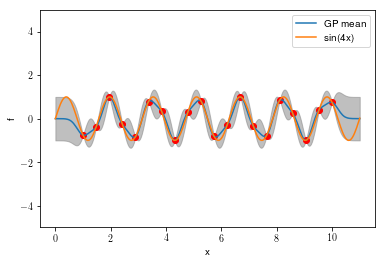

In [10]:
# The training points and training values
X = np.linspace(1,10,20).reshape(-1,1)
ferr = 1e-1
f = np.sin(4.*X)#+np.random.normal(0.,ferr,size=X.shape)

# The test points and real values of f at test points
Xstar = np.linspace(0,11,300).reshape(-1,1)
fstar = np.sin(4.*Xstar)

# Choose a kernel, nugget, and compute covariance matrices
length_scale = .05
cov_scale = 1.
KXX = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
KXXstar = cov_scale*squared_exponential_kernel(Xstar,X,scale=length_scale,metric=None)

nugget_val = 1e-2
nugget = np.diag((nugget_val**2)*np.ones(X.shape[0]))

# Steps 1-2
L = LA.cholesky(KXX+nugget,lower=True)
alpha = LA.cho_solve((L,True), f)

# Steps 3-5
fstar_bar = np.dot(KXXstar,alpha)
variances = []
for i in range(KXXstar.shape[0]):
    v = LA.solve_triangular(L,KXXstar[i,:],lower=True)
    variances.append(cov_scale-np.dot(v.T,v))
stds = np.sqrt(variances)

# Step 6
lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (X.shape[0]/2.)*np.log(2*np.pi)
lml = lml.flatten()[0]
print ( "The log likelihood is" , lml )

plt.plot(X,f,'ro')
plt.plot(Xstar,fstar_bar,label='GP mean')
plt.plot(Xstar,fstar,label='sin(4x)')

Xstar_flat,fstar_bar_flat=Xstar.flatten(),fstar_bar.flatten()
plt.fill_between(Xstar_flat,fstar_bar_flat-stds,fstar_bar_flat+stds,alpha=0.5,color='gray')
plt.ylim([-5,5])
plt.xlabel('x')
plt.ylabel('f')
plt.legend()
plt.show()

## 4.3 Choosing the Kernel and Hyperparameters:

The kernel and it's associated hyperparameters are the bedrock of the Gaussian process regression and determine the overall morphology of the interpolations.  In most cases of interpolating smooth functions, the squared-exponential will suffice, and in simple cases one can even hand tune the hyperparameters.  In the machine-learning context though, one is more interested in fitting the hyperparameters to maximize some objective function of the observed data.  The squared-exponential kernel may not be right for all cases, either, as we shall see.  

The most natural objective function for deciding on kernel and/or hyperparameter choice is the log marginal likelihood, i.e. the probability of the observed data given the kernel/hyperparameter choice $p(f|k,\theta)$.  I call this the "hyperlikelihood". Let's perform the same interpolation as above but choose hyperparameters that maximize this.  One can also optionally introduce a "hyperprior" $p(\theta)$, ie. a prior distribution on hyperparameter values. This can be helpful if the marginal likelihood is not well behaved or has many local minima.  The "hyperposterior" $p(\theta|f)$ is given by:

$$ p(\theta,k|f) \propto p(f|k,\theta)p(\theta,k) $$

In [11]:
# set underflow errors to be ignored rather than warning
np.seterr(divide='raise',under='ignore',over='raise')

def log_marginal_likelihood(theta,X,f,sign=1,cholesky=True,kernel='SE'):
    """
    Compute the log_marginal_likelihood of data f
    at points X under GP given by covariance K
    
    Parameters
    ----------
    theta: array
        array of hyperparameters 10**[nugget_val,cov_scale,length_scale]
    X: array
        array of GP input points
    f: array
        array of data at X
    sign: float
        A multiplier that is meant to be 1 or -1 
        depending on if one wants the negative or 
        positive log marginal likelihood
    cholesky: bool
        Whether to use cholesky or 
        direct matrix inversion
    kernel: str
        SE, Matern32, or Matern52
    
    Returns
    -------
    lml: float
        log marginal likelihood of data f
    """
    
    try:
        cov_scale = 10.**theta[0]
        length_scale = 10.**theta[1]
    except FloatingPointError:
        return -np.inf*sign
    try:
        if kernel == 'SE':
            K = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
        elif kernel == 'Matern32':
            K = cov_scale*Matern32(X,X,scale=length_scale,metric=None)
        elif kernel == 'Matern52':
            K = cov_scale*Matern52(X,X,scale=length_scale,metric=None)
        if np.any(np.isnan(K)):
            return -np.inf*sign
        nugget = np.diag((10.**theta[2])*np.ones(X.shape[0]))
        if cholesky:
            L = LA.cholesky(K+nugget,lower=True)
            alpha = LA.cho_solve((L,True), f)
            lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (X.shape[0]/2.)*np.log(2*np.pi)
            lml = lml.flatten()[0]
        else:
            Kinv = LA.inv(KXX+nugget)
            alpha = np.dot(Kinv,f)
            # Steps 3-5
            variances = []
            for i in range(KXXstar.shape[0]):
                v = np.dot(KXXstar[i,:].T,np.dot(Kinv,KXXstar[i,:]))
                variances.append(v)
            stds = np.sqrt(variances)
            # Step 6
            lml = -(1./2.)*np.dot(f.T,alpha) - 0.5*np.log(np.linalg.det(Kinv)) - (X.shape[0]/2.)*np.log(2*np.pi)
            lml = lml.flatten()[0]
    except FloatingPointError:
        return -np.inf*sign
    return lml*sign

        
from scipy.stats import norm
def log_hyperprior(theta,theta_means,theta_widths,prior_type='normal'):
    """
    The log hyperprior
    
    Parameters
    ----------
    theta: array
        array of parameter values
    theta_means: array
        array of mean values of theta
    theta_widths: array
        gaussian widths of theta values
    prior_type: string
        either normal or box
    
    Returns
    -------
    log_h: float
        log hyperprior
    """
    log_h = 0.
    for i in range(len(theta)):
        try:
            if prior_type=='normal':
                log_h = log_h + np.log(norm.pdf(theta[i], theta_means[i], theta_widths[i]))
            else:
                if ~((theta[i]>(theta_means[i]-theta_widths[i])) and 
                    (theta[i]<(theta_means[i]+theta_widths[i]))):
                    log_h = -np.inf
                else:
                     pass                                                     
        except:
            -np.inf
    return log_h

def log_hyperposterior(theta,X,f,
                       theta_means,theta_widths,
                       sign=1,cholesky=True,
                       kernel='SE',prior_type='normal'):
    """
    The log hyperposterior
    
    Parameters
    ----------
    theta: array
        array of hyperparameters
    X: array
        array of GP input points
    f: array
        array of data at X
    theta_means: array
        array of mean values of lognormal prior
    theta_widths: array
        widths of lognormal prior
    sign: float
        1 or -1 depending on if negative 
        log hyperposterior is wanted
    cholesky: bool
        Whether to use cholesky or 
        direct matrix inversion
    kernel: str
        SE, Matern32, or Matern52
    prior_type: str
        either normal or box
    
    Returns
    -------
    log_hyperposterior: float
        the log hyperposterior
    """
    hyperpos = (log_marginal_likelihood(theta,X,f,cholesky=cholesky,kernel=kernel)+
                log_hyperprior(theta,theta_means,theta_widths,prior_type))
    if np.isnan(hyperpos):
        return -np.inf*sign
    else:
        return hyperpos*sign

If you want a look at the hyperlikelihood or hyperposterior as a function of the hyperparameters, you can use an mcmc:

In [55]:
# specify number of dimensions and walkers
ndim, nwalkers = 3, 20

# specify prior center values and prior widths 
# of each hyperparameter (log sigma ^2, log l, and log nugget)
theta_means = [0.0,0.0,-3]
theta_widths = [2.,3.,3.] # order of mag width on covariance and length, 0.1 orders on nugget

# instantiate the sampler using a squared exponential kernel and box prior
sampler = mc.EnsembleSampler(nwalkers, ndim, log_hyperposterior, args=(X, f,theta_means,theta_widths,1,True,'SE','box'))

# choose initial walker positions
pos = [[0.,0.,-3.] + 0.5*np.random.randn(ndim) for i in range(nwalkers)]

# run mcmc 
sampler.run_mcmc(pos, 500);

# plot samples
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
corner.corner(samples, labels=["$\log_{10}\sigma^2$", "$\log_{10} l$","$\log_{10}$ nugget"]);

emcee: Exception while calling your likelihood function:
  params: [ 1.97556541  0.5325469  -4.10748408]
  args: (array([[0.07738852],
       [0.        ],
       [0.65670551],
       [0.73473935],
       [0.38545775],
       [0.87334894],
       [0.69353614],
       [0.94967709],
       [1.        ],
       [0.23142627]]), array([[ 1.45367548],
       [ 1.7922107 ],
       [-0.38429308],
       [-0.56486015],
       [ 0.35887922],
       [-0.87229813],
       [-0.48272236],
       [-1.03266968],
       [-1.1297128 ],
       [ 0.8617908 ]]), [0.0, 0.0, -3], [2.0, 3.0, 3.0], 1, True, 'SE', 'box')
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/christophermoore/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-11-d421bb586246>", line 141, in log_hyperposterior
    hyperpos = (log_marginal_likelihood(theta,X,f,cholesky=cholesky,kernel=kernel)+
  File "<ipython-input-11-d421bb586246>", line 40, in log_marginal_likelihood
    K = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
  File "<ipython-input-6-3d001eb42d51>", line 43, in squared_exponential_kernel
    K[i,j] = np.exp(-0.5*(dist(X1[i,:],X2[j,:])**2))
  File "<ipython-input-6-3d001eb42d51>", line 36, in <lambda>
    dist = lambda a,b: np.sqrt(np.dot(np.dot(a-b,inv_scale),a-b))
KeyboardInterrupt


KeyboardInterrupt: 

You may notice that there are multiple local extrema to the objective functions we are trying to maximize/minimize.  As a result, some tweaking or multiple optimizer restarts may be required if we want to just use the hyperparameters at extrema of the objective function.  One could in principle take an even more Bayesian approach and marginalize over hyperparameters rather than choosing one set of hyperparameters.  This would be total overkill in most applications. It's also worth noting that the hyperposterior's profile is telling us about different ways to explain the data (duh, it's Bayes!).  In this case with the sinusoidal data, it could be that all the data could be explained as mostly noise or it could instead be that there is a small amount of noise in the data and that $\sigma^2 \sim 10^{-0.4}$ and $l \sim 10^{-2}$.  In some cases you may know the noise level, in which case it can be fixed and the other hyperparameters can be optimized.  Let's fix the nugget to 1e-2 and see how the other hyperparameters are optimized:


In [ ]:
# specify number of dimensions and walkers
ndim, nwalkers = 3, 20

# specify prior center values and prior widths 
# of each hyperparameter (log sigma ^2, log l, and log nugget)
theta_means = [0.0,0.0,-2]
theta_widths = [2.,3.,0.01] # 2 and 3 orders of mag width on covariance and length, 0.1 orders on nugget

# instantiate the sampler using a squared exponential kernel and box prior
sampler = mc.EnsembleSampler(nwalkers, ndim, log_hyperposterior, args=(X, f,theta_means,theta_widths,1,True,'SE','box'))

# choose initial walker positions
pos = [[0.,0.,-2.] + 0.1*np.random.randn(ndim) for i in range(nwalkers)]

# run mcmc
sampler.run_mcmc(pos, 500);

# plot samples
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
corner.corner(samples, labels=["$\log_{10}\sigma^2$", "$\log_{10} l$","$\log_{10}$ nugget"]);

Let's minimize the negative log marginal likelihood for data f assuming a "nugget" of 1e-2.  In order to make the minimization easy, we've used the above corner plots to inform the hyperprior to carve out the area of parameter space where we want the minimizer to search:


In [52]:
minres = None
minresval = np.inf
bounds = ([-0.5,0.0],[-3,1.],[-2.1,-1.92])
x0 = [-0.25,-2.,-2.]
res = spo.minimize(log_hyperposterior,
                   x0=x0,
                   args=(X,f,theta_means,theta_widths,-1.,True,'SE','normal'),
                   bounds = bounds,
                  )
print ( res )

      fun: 3.9238890199401926
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.89682580e+00, -1.95399252e-06,  5.95115388e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 44
      nit: 7
   status: 0
  success: True
        x: array([ 0.        , -0.58729589, -2.1       ])


The log likelihood is 10.031889158424368


ValueError: x and y must have same first dimension, but have shapes (9, 1) and (300, 1)

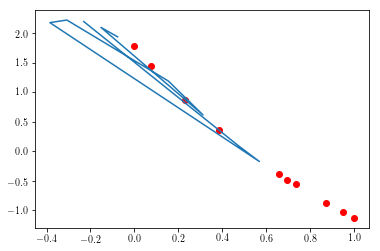

In [54]:

# Use optimized hyperparameters
cov_scale = 10**res["x"][0]
length_scale = 10**res["x"][1]
nugget_val = 10**res["x"][2]

nugget = np.diag(nugget_val*np.ones(X.shape[0]))

KXX = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
KXXstar = cov_scale*squared_exponential_kernel(Xstar,X,scale=length_scale,metric=None)

# Steps 1-2
L = LA.cholesky(KXX+nugget,lower=True)
alpha = LA.cho_solve((L,True), f)

# Steps 3-5
fstar_bar = np.dot(KXXstar,alpha)
variances = []
for i in range(KXXstar.shape[0]):
    v = LA.solve_triangular(L,KXXstar[i,:],lower=True)
    variances.append(cov_scale-np.dot(v.T,v))
stds = np.sqrt(variances)

# Step 6
lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (1./2.)*np.log(2*np.pi)
lml = lml.flatten()[0]
print ( 'The log likelihood is' , lml )

plt.plot(X,f,'ro')
plt.plot(Xstar,fstar_bar,label='GP mean')
plt.plot(Xstar,fstar,label='sin(4x)')

Xstar_flat,fstar_bar_flat=Xstar.flatten(),fstar_bar.flatten()
plt.fill_between(Xstar_flat,fstar_bar_flat-stds,fstar_bar_flat+stds,alpha=0.5,color='gray')
plt.ylim([-5,5])
plt.xlabel('x')
plt.ylabel('f')
plt.legend()

plt.figure()
plt.scatter(Xstar,np.divide(np.abs(fstar-fstar_bar).flatten(),stds),label='mean residual')
plt.xlabel('x')
plt.ylabel(r'$\frac{f-\overline{f}}{\delta f_{GP}}$',fontsize=18);

plt.show()


We've now finished running a trained Gaussian Process Regression!  

## 5.0 Gaussian Process Regression: A Gravitational Wave Example

Now let's look at a gravitational-wave example!  Rather than interpolate full waveforms, which is beyond what we have time for in this tutorial, we will instead interpolate fraction of mass loss from binary mergers as a function of mass ratio.  At our disposal, we have SXS simulations of black hole mergers.  Some outputs of these simulations include radiated energies.  Let's first get the data and plot it:

In [39]:
def LoadMetaData ( ID ):
    
    fname = "GPR_Chris_Zoheyr/data/SXS_data/" + ID + "/metadata" + ID.split('-')[1] + ".txt"
    fname = "../data/SXS_data/" + ID + "/metadata" + ID.split('-')[1] + ".txt"
    
    with open(fname) as f:
        content = f.readlines()
    
    for line in content:
        if "relaxed-mass1" in line:
            relaxed_mass1 = float ( line.split()[-1] )
        elif "relaxed-mass2" in line:
            relaxed_mass2 = float ( line.split()[-1] )
        elif "remnant-mass" in line:
            remnant_mass = float ( line.split()[-1] )
    
    total_mass = relaxed_mass1 + relaxed_mass2
    mass_ratio = relaxed_mass1 / relaxed_mass2
    Delta_E = ( total_mass - remnant_mass ) / total_mass
    
    return np.array ( [ mass_ratio , Delta_E ] )

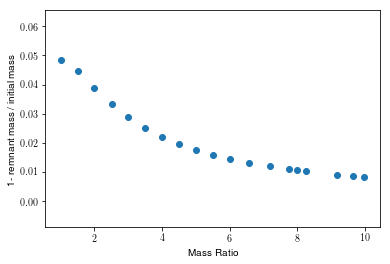

In [43]:
import os
#ids = os.listdir ( "GPR_Chris_Zoheyr/data/SXS_data/" )
ids = os.listdir ( "../data/SXS_data/" )
ids = [ ID for ID in ids if "SXS" in ID ]
mass_ratios = []
energies = []
# extract energies and mass ratios from each file
for idval in ids:
    mass_ratio, Delta_E = LoadMetaData ( idval )
    mass_ratios.append(mass_ratio)
    energies.append(Delta_E)
    

mass_ratios,energies = np.array(mass_ratios),np.array(energies)
plt.scatter(mass_ratios,energies)
plt.xlabel('Mass Ratio')
plt.ylabel('1- remnant mass / initial mass')
plt.show()


Unsurprisingly, the remnant mass over the initial mass goes to zero as the mass ratio $q$ is increased. This makes sense in the high mass ratio limit where one would expect no energy radiated from throwing a teeny black hole into a super-massive one.  Let's start by breaking the data set into a training set and a validation set.  We'll use 10 of the 19 simulations to train, and move to log space for fractional energy radiated: 

In [44]:
np.random.seed(0)
indices = np.random.choice(range(len(mass_ratios)),replace=False,size=10)
sel = np.in1d(np.array(range(len(mass_ratios))),indices)
q_train = mass_ratios[sel] # q values training set
q_val = mass_ratios[~sel] # q values validation set 
E_train = np.log10(energies[sel]) # log(deltaE) values training set
E_val = np.log10(energies[~sel]) # log(deltaE) values validation set

Before we interpolate, we should whiten our data by removing the mean and normalizing by the standard deviation.  We can also normalize q_train to be between 0 and 1.  This is a very helpful move in general, because that way we can use the same hyperparameter bounds in all interpolations.

In [45]:
# Whiten data
E_train_mean = np.mean(E_train)
E_train_std = np.std(E_train)
E_train_whitened = ((E_train-E_train_mean)/E_train_std).reshape(-1,1)
E_val_whitened = ((E_val-E_train_mean)/E_train_std).reshape(-1,1)

# Normalize input range
q_train_min = np.amin(q_train)
q_train_max = np.amax(q_train)
q_train_whitened = ((q_train-q_train_min)/(q_train_max-q_train_min)).reshape(-1,1)
q_val_whitened = ((q_val-q_train_min)/(q_train_max-q_train_min)).reshape(-1,1)

Now let's train the GP:

/Users/christophermoore/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/christophermoore/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
/Users/christophermoore/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: -3.584572273799715
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.8146154 , -2.21665779,  6.37214228])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 1
   status: 0
  success: True
        x: array([ 0.8024564 , -0.05274803, -2.15501009])


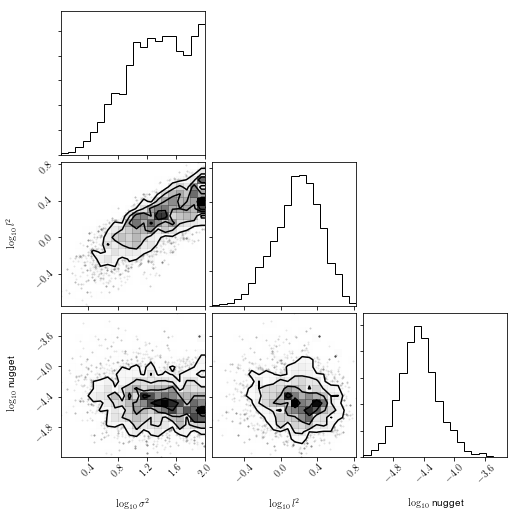

In [47]:
# specify number of dimensions and walkers
ndim, nwalkers = 3, 20

# specify prior center values and prior widths
# of each hyperparameter (log sigma ^2, log l, and log nugget)
theta_means = [0.0,0.0,-4.]
theta_widths = [2,2,4]

# instantiate the sampler using a squared exponential kernel and box prior
sampler = mc.EnsembleSampler(nwalkers, ndim, log_hyperposterior, 
                             args=(q_train_whitened, E_train_whitened,theta_means,theta_widths,1,True,'SE','box'))

# choose initial walker positions
pos = [[0.,0.,-2.] + np.random.randn(ndim) for i in range(nwalkers)]

# run mcmc
sampler.run_mcmc(pos, 500);

# plot samples
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
corner.corner(samples, labels=["$\log_{10}\sigma^2$", "$\log_{10} l^2$","$\log_{10}$ nugget"]);

# run the optimizer too to find the max hyperposterior.  We'll do a few restarts
# since the optimizer can misbehave

reslist = []
minhpi = None
minhp = np.inf
for i in range(20):
    res = spo.minimize(log_hyperposterior,x0=[0.0,-1.,-2]+ np.random.randn(ndim),
                       args=(q_train_whitened, E_train_whitened,theta_means,theta_widths,-1.,True,'SE','box'),
                       bounds=([-2,2],[-2,2],[-8,0]))
    reslist.append(res)
    if res["fun"]< minhp:
        minhp = res["fun"]
        minhpi = i
print ( reslist[minhpi] )

The log likelihood is 3.584572273799715


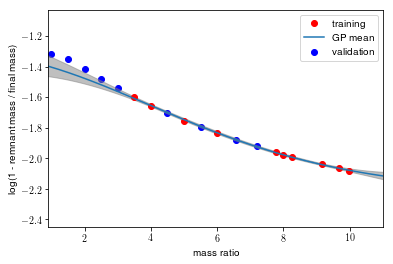

In [48]:
# define training input and output
X = q_train_whitened
f = E_train_whitened

# define points of interest in interpolation
Xstar = np.linspace(-1.,2.,500).reshape(-1,1)

# Use optimized hyperparameters
res = reslist[minhpi]
cov_scale = 10**res["x"][0]
length_scale = 10**res["x"][1]
nugget_val = 10**res["x"][2]
nugget = np.diag(nugget_val*np.ones(X.shape[0]))

KXX = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
KXXstar = cov_scale*squared_exponential_kernel(Xstar,X,scale=length_scale,metric=None)

#---Do GPR---#

# Steps 1-2
L = LA.cholesky(KXX+nugget,lower=True)
alpha = LA.cho_solve((L,True), f)

# Steps 3-5
fstar_bar = np.dot(KXXstar,alpha)
variances = []
for i in range(KXXstar.shape[0]):
    v = LA.solve_triangular(L,KXXstar[i,:],lower=True)
    variances.append(cov_scale-np.dot(v.T,v))
stds = np.sqrt(variances)

# Step 6
lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (X.shape[0]/2.)*np.log(2*np.pi)
lml = lml.flatten()[0]
print ('The log likelihood is',lml)

# plotting and some gymnastics to undo whitening
plt.plot(q_train,E_train,'ro',label='training')
plt.scatter(q_val,E_val,color='b',label='validation')
qstar = Xstar*(q_train_max-q_train_min)+q_train_min
Estar_bar = fstar_bar*E_train_std+E_train_mean
plt.plot(qstar,Estar_bar,label='GP mean')
qstar_flat,Estar_bar_flat=qstar.flatten(),Estar_bar.flatten()
stds = stds*E_train_std
plt.fill_between(qstar_flat,Estar_bar_flat-stds,Estar_bar_flat+stds,alpha=0.5,color='gray')
plt.xlabel('mass ratio')
plt.ylabel('log(1 - remnant mass / final mass)')
plt.xlim([0.9,11.])
plt.legend()

And now let's compare our GP uncertainties to the residuals with the mean

The log likelihood is 3.584572273799715


(0.9, 11.0)

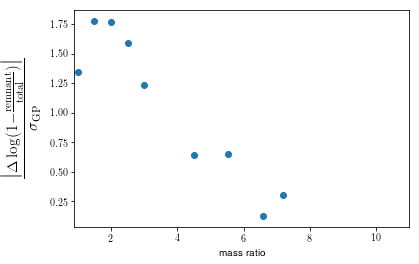

In [49]:
X = q_train_whitened
f = E_train_whitened
Xstar = q_val_whitened
# Use optimized hyperparameters

cov_scale = 10**res["x"][0]
length_scale = 10**res["x"][1]
nugget_val = 10**res["x"][2]
nugget = np.diag(nugget_val*np.ones(X.shape[0]))
KXX = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
KXXstar = cov_scale*squared_exponential_kernel(Xstar,X,scale=length_scale,metric=None)

# Steps 1-2
L = LA.cholesky(KXX+nugget,lower=True)
alpha = LA.cho_solve((L,True), f)

# Steps 3-5
fstar_bar = np.dot(KXXstar,alpha)
variances = []
for i in range(KXXstar.shape[0]):
    v = LA.solve_triangular(L,KXXstar[i,:],lower=True)
    variances.append(cov_scale-np.dot(v.T,v))
stds = np.sqrt(variances)

# Step 6
lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (X.shape[0]/2.)*np.log(2*np.pi)
lml = lml.flatten()[0]
print ('The log likelihood is',lml)


plt.scatter(q_val,np.absolute(fstar_bar - E_val_whitened).flatten()/stds,label='mean residual')
plt.xlabel('mass ratio')
plt.ylabel(r'$\frac{\big|\Delta\log({1-\frac{\rm remnant}{\rm total}})\big|}{\sigma_{\rm GP}}$',fontsize=22)
plt.xlim([0.9,11.])

### Final Investigations
* How do the residuals look?
* If the residuals don't match the expected uncertainties, what changes could you make to e.g. your kernel in order to fix it?